# Historical Portfolio Optimization of Major Exchange Indices
By Aric Cutuli<br>
August 22, 2021
***

In this notebook, we will be exploring an exciting [dataset](https://www.kaggle.com/mattiuzc/stock-exchange-data 'Kaggle') that documented daily market data of 12 major stock exchange indices from around the world over a span of over 50 years. Our goal is to apply traditional portfolio optimization theory to discover what an optimal portfolio of this data looks like.

Initially collected from Yahoo Finance, the data has been processed to remove null values and include a column that standardizes closing prices into USD.<br>
The 12 indices we will be delving into are:
* __Nikkei 225 (N225)__: stock market index for the Tokyo Stock Exchange
* __NYSE Composite (NYA)__: monitors all common stock at the New York Stock Exchange
* __Nasdaq Composite (IXIC)__: tracks almost all stocks on the Nasdaq stock exchange
* __S&P/TSX Composite Index (GSPTSE)__: tracks around 250 of the largest companies on the Toronto Stock Exchange
* __Hang Seng Index (HSI)__: monitors the 50 largest companies listed on the Hong Kong Stock Exchange
* __DAX Performance Index (GDAXI)__: index of the 30 major German blue chip companies listed on the Frankfurt Stock Exchange
* __Swiss Market Index (SSMI)__: monitors the 20 largest Swiss Performance Index stocks
* __SSE Composite Index (000001.SS)__: follows all stocks traded on the Shanghai Stock Exchange
* __Taiwan Weighted Index (TWII)__: tracks almost all companies traded on the Taiwan Stock Exchange
* __SZSE Component Index (399001.SZ)__: index of 500 stocks traded at the Shenzhen Stock Exchange
* __Euronext 100 (N100)__: blue chip index of the pan-European exchange
* __NIFTY 50 (NSEI)__: follows a weighted average of 50 of the largest companies on the National Stock Exchange of India
* __JSE All Share Index (J203.JO)__: follows the 164 largest companies of the Johannesburg Stock Exchange

# Contents
[Observing the Data and Daily Returns](#Observing-the-Data-and-Daily-Returns)<br>
[Modern Portfolio Theory and Asset Correlation](#Modern-Portfolio-Theory-and-Asset-Correlation)<br>
[Building Our Portfolio](#Building-Our-Portfolio)<br>
[Monte Carlo Simulation](#Monte-Carlo-Simulation)<br>
[Optimization Algorithm](#Optimization-Algorithm)<br>
[Reflections](#Reflections)

# Observing the Data and Daily Returns

To begin, let's import and separate the dataset to create a DataFrame for each index.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
indexData = pd.read_csv('indexProcessed.csv',index_col='Date').sort_index()

In [3]:
indexArray = indexData['Index'].unique()
indexDict = {}
for index in indexArray:
    indexDict["df{0}".format(index)] = indexData[indexData['Index'] == index]

We can now call `indexDict['dfHSI'].head()`, for example, to observe price information for the Huang Seng Index for a few past trading days.

In [4]:
indexDict['dfHSI'].head()

,Index,Open,High,Low,Close,Adj Close,Volume,CloseUSD
Date,,,,,,,,
1986-12-31,HSI,2568.300049,2568.300049,2568.300049,2568.300049,2568.300049,0.0,333.879006
1987-01-02,HSI,2540.100098,2540.100098,2540.100098,2540.100098,2540.100098,0.0,330.213013
1987-01-05,HSI,2552.399902,2552.399902,2552.399902,2552.399902,2552.399902,0.0,331.811987
1987-01-06,HSI,2583.899902,2583.899902,2583.899902,2583.899902,2583.899902,0.0,335.906987
1987-01-07,HSI,2607.100098,2607.100098,2607.100098,2607.100098,2607.100098,0.0,338.923013


To get a better idea of what we're looking at, let's plot the data by closing price in USD.

In [5]:
indexCloseUSD = []
for index in indexArray:
    indexCloseUSD.append(indexDict["df{0}".format(index)]['CloseUSD'])
df_indexCloseUSD = pd.concat(indexCloseUSD,axis=1).sort_index()
df_indexCloseUSD.columns = indexArray

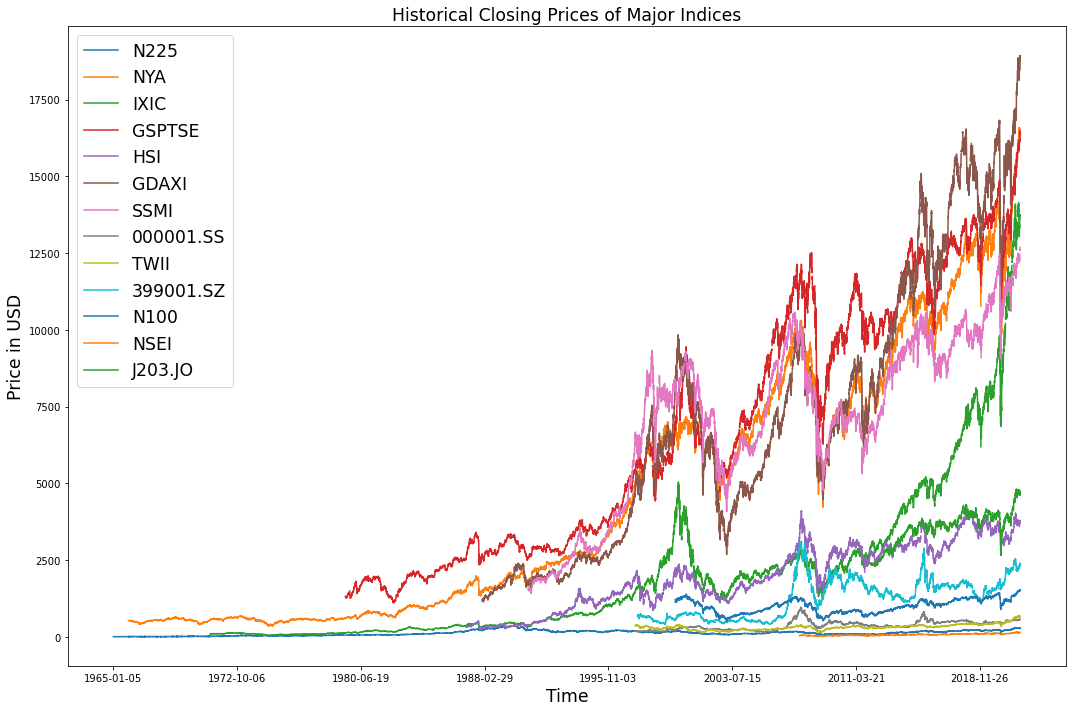

In [6]:
df_indexCloseUSD['N225'].plot(label='N225',figsize=(15,10))
df_indexCloseUSD['NYA'].plot(label='NYA')
df_indexCloseUSD['IXIC'].plot(label='IXIC')
df_indexCloseUSD['GSPTSE'].plot(label='GSPTSE')
df_indexCloseUSD['HSI'].plot(label='HSI')
df_indexCloseUSD['GDAXI'].plot(label='GDAXI')
df_indexCloseUSD['SSMI'].plot(label='SSMI')
df_indexCloseUSD['000001.SS'].plot(label='000001.SS')
df_indexCloseUSD['TWII'].plot(label='TWII')
df_indexCloseUSD['399001.SZ'].plot(label='399001.SZ')
df_indexCloseUSD['N100'].plot(label='N100')
df_indexCloseUSD['NSEI'].plot(label='NSEI')
df_indexCloseUSD['J203.JO'].plot(label='J203.JO')
plt.title('Historical Closing Prices of Major Indices',fontsize='xx-large')
plt.xlabel('Time',fontsize='xx-large')
plt.ylabel('Price in USD',fontsize='xx-large')
plt.legend(fontsize='xx-large')
plt.tight_layout();

Yes, the chart is quite hard to read, and we could digress further by plotting the [moving averages](https://www.investopedia.com/terms/m/movingaverage.asp 'Investopedia - Moving Average') to more clearly see which index generated the most return, but that is not the main focus of this analysis. We plan to discuss the concept of a classically optimal portfolio and apply it to these indices.

What we do see clearly, however, is that not all index data is present for each point in time, and while this is a startling find, there is still significant data to produce quality analysis from.

While one might think it a clever idea to employ an [ARIMA model](https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/ 'Machinelearningplus - ARIMA Model') to predict and fill in the missing data, the [Brownian](https://en.wikipedia.org/wiki/Brownian_model_of_financial_markets 'Wikipedia - Brownian model of financial markets') nature of stock price movements renders this idea useless.

To begin comparing the indices for the purposes of our analysis, we will generate a daily percent change column for each DataFrame and ignore the warning output.

In [7]:
for index in indexArray:
    indexDict["df{0}".format(index)]['Daily % Change'] = indexDict["df{0}".format(index)]['CloseUSD'].pct_change(1)*100

<ipython-input-7-7482c67e588e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indexDict["df{0}".format(index)]['Daily % Change'] = indexDict["df{0}".format(index)]['CloseUSD'].pct_change(1)*100


Now, when we call `indexDict['dfHSI'].head()`, we see an additional column displaying the daily percent change for the Huang Seng Index.

In [8]:
indexDict['dfHSI'].head()

,Index,Open,High,Low,Close,Adj Close,Volume,CloseUSD,Daily % Change
Date,,,,,,,,,
1986-12-31,HSI,2568.300049,2568.300049,2568.300049,2568.300049,2568.300049,0.0,333.879006,NaN
1987-01-02,HSI,2540.100098,2540.100098,2540.100098,2540.100098,2540.100098,0.0,330.213013,-1.098001
1987-01-05,HSI,2552.399902,2552.399902,2552.399902,2552.399902,2552.399902,0.0,331.811987,0.484225
1987-01-06,HSI,2583.899902,2583.899902,2583.899902,2583.899902,2583.899902,0.0,335.906987,1.234133
1987-01-07,HSI,2607.100098,2607.100098,2607.100098,2607.100098,2607.100098,0.0,338.923013,0.897875


After some DataFrame concatenation, we can a generate a [box plot](https://www.simplypsychology.org/boxplots.html 'Simply Psychology - Box Plots') that displays daily percent changes of the various indices.

In [9]:
indexChange = []
for index in indexArray:
    indexChange.append(indexDict["df{0}".format(index)]['Daily % Change'])  
df_indexChange = pd.concat(indexChange,axis=1).sort_index()
df_indexChange.columns = indexArray

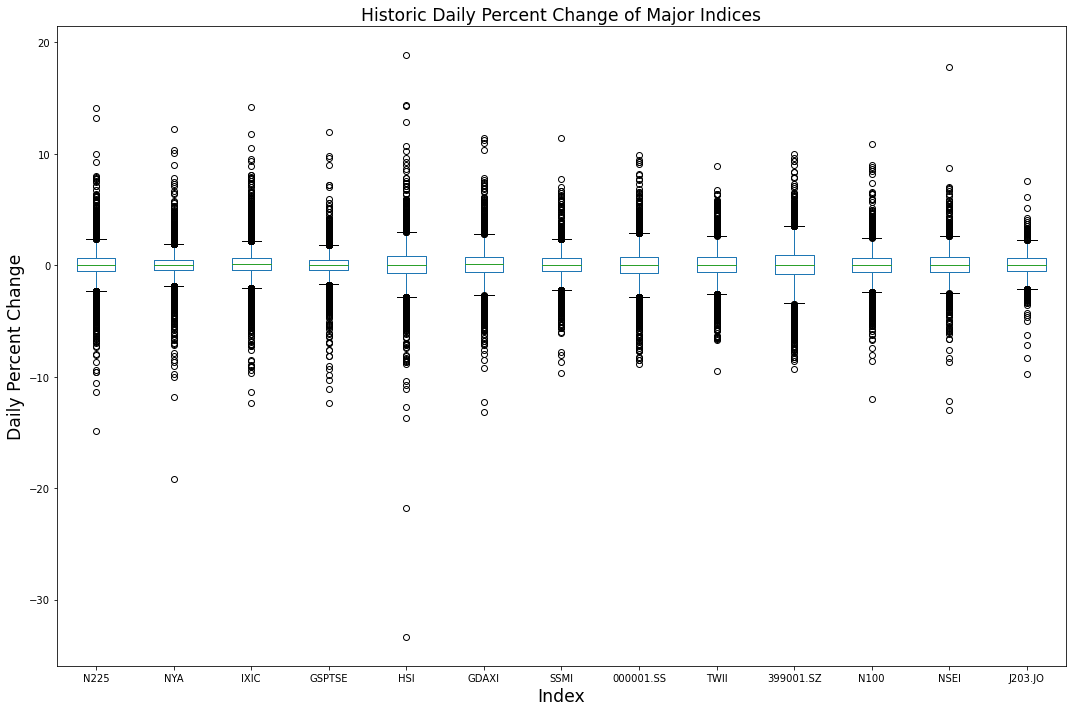

In [10]:
df_indexChange.plot(kind='box',figsize=(15,10))
plt.ylabel('Daily Percent Change',fontsize='xx-large')
plt.xlabel('Index',fontsize='xx-large')
plt.title('Historic Daily Percent Change of Major Indices',fontsize='xx-large')
plt.tight_layout();

Interesting! We see relatively high volatility in some indices and lower volatility in others. 

In [11]:
df_indexChange.describe()

,N225,NYA,IXIC,GSPTSE,HSI,GDAXI,SSMI,000001.SS,TWII,399001.SZ,N100,NSEI,J203.JO
count,13873.000000,13946.000000,12689.000000,10525.000000,8491.000000,8437.000000,7670.000000,5790.000000,5868.000000,5759.000000,5473.000000,3345.000000,2345.000000
mean,0.030738,0.029978,0.046670,0.028657,0.041861,0.042265,0.033904,0.031059,0.020386,0.037166,0.012914,0.047415,0.034855
std,1.271525,1.024518,1.252742,0.986597,1.613130,1.405671,1.131312,1.547113,1.375609,1.752849,1.313654,1.431102,1.055926
min,-14.900944,-19.173303,-12.321331,-12.344690,-33.330359,-13.143396,-9.637362,-8.840630,-9.458342,-9.289782,-11.972190,-12.980466,-9.721262
25%,-0.536659,-0.424544,-0.443262,-0.389100,-0.657958,-0.632952,-0.519025,-0.675806,-0.607979,-0.825094,-0.584086,-0.582354,-0.478719
50%,0.040191,0.051665,0.107868,0.065272,0.063722,0.080426,0.065266,0.057377,0.043224,0.034491,0.056938,0.066500,0.053736
75%,0.633706,0.513987,0.610935,0.502157,0.804379,0.749194,0.616804,0.757611,0.698259,0.906421,0.643140,0.699756,0.617218
max,14.150312,12.216238,14.173196,11.957070,18.823600,11.401954,11.390958,9.857048,8.893237,9.998730,10.873089,17.744066,7.531619


Looking closer at the quantitative characteristics of the data, we can see the mean daily percent change and the standard deviation of these changes, attributes that will come into play as we generate our portfolio. Keep an eye on the indices with high means and low standard deviations.

# Modern Portfolio Theory and Asset Correlation

Nobel Prize winning economist Harry Markowitz's [__Modern Portfolio Theory (MPT)__](https://www.investopedia.com/terms/m/modernportfoliotheory.asp 'Investopedia - MPT') stresses that investors should construct portfolios that seek to maximize expected return given some level of risk tolerance. In effect, portfolio optimization, according to MPT, depends on statistical measures such as [correlation](https://www.investopedia.com/terms/c/correlation.asp 'Investopedia - Correlation') and [variance](https://www.investopedia.com/terms/v/variance.asp 'Investopedia - Variance') to monitor risk.

Diversifying a portfolio across a large, uncorrelated pool of assets is, in theory, useful for managing exposure to directional risk and avoiding unsystematic risk.
* __Directional risk__ arises as a result of relying too heavily on a certain stock or sector.
* __Unsystematic risk__ is the risk associated with a certain stock or sector. Systematic risk is the risk inherent to an entire market.

Let's discuss correlation more closely by creating a correlation matrix documenting the individual relationships between the indices. Recall that a negative correlation coefficient indicates a negative correlation between two indices, a positive correlation coefficient indicates a positive correlation, a correlation coefficient with an absolute value close to 1 indicates a strong correlation, and a correlation coefficient close to 0 indicates a weak correlation.

In [12]:
correlation_matrix = df_indexChange.corr()
correlation_matrix = correlation_matrix.where(np.tril(np.ones(correlation_matrix.shape)).astype(np.bool))
correlation_matrix

,N225,NYA,IXIC,GSPTSE,HSI,GDAXI,SSMI,000001.SS,TWII,399001.SZ,N100,NSEI,J203.JO
N225,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NYA,0.148443,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IXIC,0.139334,0.804783,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSPTSE,0.216533,0.759853,0.688549,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HSI,0.454453,0.234290,0.195509,0.269089,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GDAXI,0.270842,0.562385,0.497822,0.505255,0.331314,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SSMI,0.299204,0.511839,0.400914,0.467071,0.341768,0.764602,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
000001.SS,0.211358,0.078237,0.047912,0.094762,0.343476,0.096468,0.076891,1.000000,NaN,NaN,NaN,NaN,NaN
TWII,0.435554,0.151960,0.135444,0.180217,0.462281,0.218585,0.227084,0.203609,1.000000,NaN,NaN,NaN,NaN
399001.SZ,0.195083,0.087352,0.059750,0.105710,0.334576,0.093019,0.086585,0.928488,0.199091,1.000000,NaN,NaN,NaN


Expectedly, the indices are all positively correlated; as one goes up, the other goes up. For once, the world agrees.

Also as expected is the strong correlation between indices that track similar markets, such as __IXIC__ and __NYA__, which monitor United States exchanges, and __000001.SS__ and __399001.SZ__, which monitor Chinese exchanges. Indices of European exchanges have a strong correlation as well; __GDAXI__, __N100__, and __SSMI__ have strong correlations to each other.

As we approach building an optimal portfolio, expect one index of each pair to be weighted significantly more than the other because we want to limit our exposure to directional risk. On the other hand, pairs of indices that have very little correlation may see their allocation in our portfolio be naturally higher as a result.

Now, for what we've all been waiting for.

# Building Our Portfolio
Suppose we wish to build a portfolio of [ETFs](https://www.investopedia.com/terms/e/etf.asp 'Investopedia - Exchange Traded Fund') that follow these indices, and we want to use past data to decide how to allocate our holdings. How would we go about optimizing our return to risk ratio?

One way of going about this is by maximizing our [__Sharpe ratio__](https://www.investopedia.com/terms/s/sharperatio.asp 'Investopedia - Sharpe ratio').

The Sharpe ratio, invented by Nobel Prize winning economist William F. Sharpe, measures the expected return in excess of the risk-free rate per unit of uncertainty for an asset or portfolio. Formulaically, it is described $$S_a = \frac{E[R_a - R_e]}{\sigma_a},$$<br>where sigma is the standard deviation of the asset or portfolio. Since we are dealing with historic time series data, we use average value instead of expected value when calculating our ratio.

In practice, a U.S. Treasury bond yield is often used to represent the risk-free rate, so let's pull in some more [data](https://www.macrotrends.net/2016/10-year-treasury-bond-rate-yield-chart 'Macrotrends'). For our analysis, we will be using the 10 year treasury.

In [13]:
tenYearTreasury = pd.read_csv('10-year-treasury-yield.csv',index_col='date')
tenYearTreasury.head()

,value
date,
1965-01-05,4.2
1965-01-06,4.2
1965-01-07,4.2
1965-01-08,4.2
1965-01-11,4.2


Now, the 10 year Treasury is quoted as an annual rate, so we need to divide by 365 to get the daily rate.

In [14]:
tenYearTreasury/=365
tenYearTreasury.head()

,value
date,
1965-01-05,0.011507
1965-01-06,0.011507
1965-01-07,0.011507
1965-01-08,0.011507
1965-01-11,0.011507


### Monte Carlo Simulation

We continue by subtracting the 10 year Treasury from our daily returns and performing a [Monte Carlo simulation](https://www.investopedia.com/terms/m/montecarlosimulation.asp 'Investopedia - Monte Carlo simulation') to try and find the portfolio that maximizes our Sharpe ratio. About now is the time I should let it be made clear that this is not financial advice.

In [41]:
new_indexChange = df_indexChange.sub(tenYearTreasury.squeeze(),axis=0)

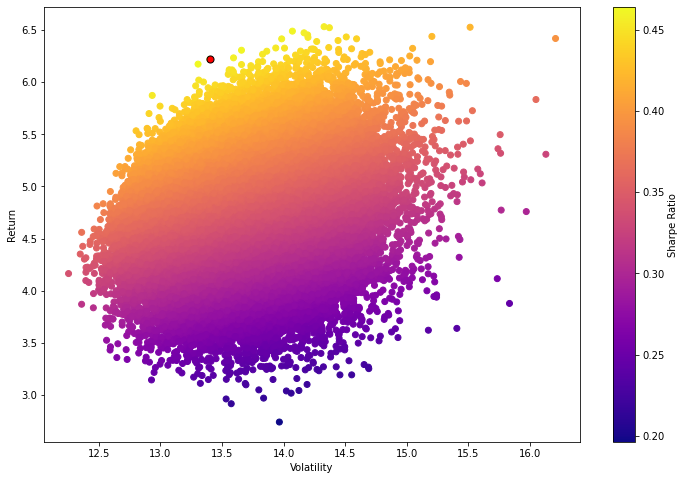

In [43]:
numPortfolios = 100000
allWeights = np.zeros((numPortfolios,len(indexArray)))
returnArray = np.zeros(numPortfolios)
volatilityArray = np.zeros(numPortfolios)
sharpeArray = np.zeros(numPortfolios)

for ind in range(numPortfolios):

    # Weights
    weights = np.array(np.random.random(len(indexArray)))
    weights /= np.sum(weights)
    
    # Save weights
    allWeights[ind,:] = weights
    
    # Expected return
    returnArray[ind] = np.sum(new_indexChange.mean()*weights*252)
    
    # Expected volatility
    volatilityArray[ind] = np.sqrt(np.dot(weights.T,np.dot(new_indexChange.cov()*252,weights)))
    
    # Sharpe Ratio
    sharpeArray[ind] = returnArray[ind]/volatilityArray[ind]
    
plt.figure(figsize=(12,8))
plt.scatter(volatilityArray,returnArray,c=sharpeArray,cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return');

# Pinpoint the maximum Sharpe Ratio
maxSharpeReturn = returnArray[sharpeArray.argmax()]
maxSharpeVolatility = volatilityArray[sharpeArray.argmax()]
plt.scatter(maxSharpeVolatility,maxSharpeReturn,c='red',s=50,edgecolor='black');

In [44]:
for ind in range(len(indexArray)):
    print(indexArray[ind] + " = " + str(np.around(allWeights[sharpeArray.argmax(),:][ind],4)))

N225 = 0.1087
NYA = 0.0357
IXIC = 0.193
GSPTSE = 0.0218
HSI = 0.0086
GDAXI = 0.0565
SSMI = 0.0527
000001.SS = 0.0723
TWII = 0.004
399001.SZ = 0.1152
N100 = 0.0156
NSEI = 0.1514
J203.JO = 0.1646


The red point identifies the one portfolio of 100,000 randomly generated portfolios that had the greatest Sharpe ratio.

In the portfolio, we see that our proposed holdings in __IXIC__, __NSEI__, __399001.SZ__, and __J203.JO__ encompass over 60% of our portfolio, but we also see in the scatter plot that our [__efficient frontier__](https://www.investopedia.com/terms/e/efficientfrontier.asp 'Investopedia - Efficent Frontier') is not fully realized by this Monte Carlo simulation.

In MPT, the efficient frontier is the set of portfolios that provide the highest level of return for a given risk tolerance. It's visualized as a curve, and any return to risk ratio to the right of the curve tells us that our portfolio is not giving us as much return as we could get for that particular risk tolerance.

### Optimization Algorithm

Since this curve is not fully fleshed out by our Monte Carlo simulation, we should dive deeper to find the true maximum Sharpe ratio by implementing an algorithm that calculates it exactly.

In [45]:
from scipy.optimize import minimize

In [46]:
def getAttributes(weights):
    weights = np.array(weights)
    ret = np.sum(new_indexChange.mean()*weights*252)
    vol = np.sqrt(np.dot(weights.T,np.dot(new_indexChange.cov()*252,weights)))
    sr = ret/vol
    return np.array([ret,vol,sr])

def negativeSharpe(weights):
    # by minimizing a negative value, we maximize its absolute value
    return getAttributes(weights)[2]*-1

def checkSum(weights):
    # checks to make sure the weights add to 1
    return np.sum(weights) - 1

cons = ({'type':'eq','fun':checkSum})
bounds = (((0,1),)*len(indexArray))
initialGuess = np.ones(len(indexArray))/len(indexArray)

optimalPortfolio = minimize(negativeSharpe,initialGuess,method='SLSQP',bounds=bounds,constraints=cons)

In [47]:
for ind in range(len(indexArray)):
    print(indexArray[ind] + " = " + str(np.around(optimalPortfolio.x[ind],4)))

N225 = 0.0
NYA = 0.0
IXIC = 0.2407
GSPTSE = 0.0
HSI = 0.0
GDAXI = 0.0
SSMI = 0.0
000001.SS = 0.0
TWII = 0.0
399001.SZ = 0.1194
N100 = 0.0
NSEI = 0.3635
J203.JO = 0.2764


We see that our optimal portfolio chooses to allocate funds into only 4 indices: __IXIC__, __399001.SZ__, __NSEI__, and __J203.JO__. While the model's objection to increased diversification seems contrarian to MPT, it actually aligns with the theory's push for allocating funds towards uncorellated assets.

In [54]:
print("IXIC-399001.SZ correlation = " + str(np.around(correlation_matrix['IXIC']['399001.SZ'],4)))
print("IXIC-NSEI correlation = " + str(np.around(correlation_matrix['IXIC']['NSEI'],4)))
print("IXIC-J203.JO correlation = " + str(np.around(correlation_matrix['IXIC']['J203.JO'],4)))
print("399001.SZ-NSEI correlation = " + str(np.around(correlation_matrix['399001.SZ']['NSEI'],4)))
print("399001.SZ-J203.JO correlation = " + str(np.around(correlation_matrix['399001.SZ']['J203.JO'],4)))
print("NSEI-J203.JO correlation = " + str(np.around(correlation_matrix['NSEI']['J203.JO'],4)))

IXIC-399001.SZ correlation = 0.0597
IXIC-NSEI correlation = 0.2723
IXIC-J203.JO correlation = 0.4125
399001.SZ-NSEI correlation = 0.2539
399001.SZ-J203.JO correlation = 0.258
NSEI-J203.JO correlation = 0.4759


Each correlation coefficient is less than 0.5, so any correlation between them can be described as weak. 

In [49]:
df_indexChange.describe().iloc[1]/df_indexChange.describe().iloc[2]

N225         0.024174
NYA          0.029260
IXIC         0.037254
GSPTSE       0.029046
HSI          0.025950
GDAXI        0.030067
SSMI         0.029969
000001.SS    0.020076
TWII         0.014820
399001.SZ    0.021203
N100         0.009831
NSEI         0.033132
J203.JO      0.033009
dtype: float64

Also, the above Series displays the mean to standard deviation ratios of daily percent changes in the indices, and three of our four champion indices have the greatest values of all.

Let's plot the efficient frontier generated by our algorithm and compare it to the scatter plot produced by our Monte Carlo simulation.

In [55]:
frontierReturn = np.linspace(1,10,100)
def minimizeVolatility(weights):
    return getAttributes(weights)[1]
frontierVolatility = []
for possibleReturn in frontierReturn:
    cons = ({'type':'eq','fun':checkSum},{'type':'eq','fun':lambda w: getAttributes(w)[0]-possibleReturn})
    result = minimize(minimizeVolatility,initialGuess,method='SLSQP',bounds=bounds,constraints=cons)
    frontierVolatility.append(result['fun'])

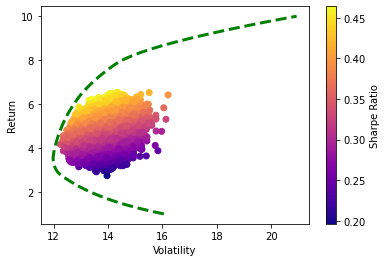

In [56]:
plt.plot(frontierVolatility,frontierReturn,'g--',lw=3);
plt.scatter(volatilityArray,returnArray,c=sharpeArray,cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return');

Now that's more like it.

As previously explained, the efficient frontier captures the set of portfolios that optimizes the expected return given some level of volatility. So if, for example, we chose the oddly specific risk tolerance of 13.291, our optimized portfolio would have an average annual return in excess of the risk-free rate of 6.818.

# Reflections

An important limitation of our analysis harkens back to the observation that not every index includes data that dates back to the start of 1965, the time our dataset begins. Because of this, it could be argued that some indices are judged more holistically than others; indices with data dating back further gives the model more to work with and potentially causes bias in the result. If one were to replicate this task, I'd recommend basing the analysis off of a dataset that has no gaps in this regard, even if it means shortening the timeframe of data.

Before we depart, I'd like to propose a possible reason for the root cause of index correlation. I believe distance between exchanges to be a primary driving force for the correlation, or lack thereof, between any two indices.

Exchanges near to each other may have similar companies listed due to [dual listing](https://www.investopedia.com/terms/d/duallisting.asp 'Investopedia - Dual Listing') and likely reflect similar [market sentiment](https://www.investopedia.com/terms/m/marketsentiment.asp 'Investopedia - Market Sentiment') because macroeconomic factors grow more similar as distance decreases.

On the opposite side of the spectrum, in distant regions of the world, two stock exchanges likely have very different companies listed and face different macroeconomic and geopolitical circumstances that affect market sentiment in unrelated ways.

This is particularly evident in the case of the three indices that make up our optimal portfolio. New York City, Shenzhen, Mumbai, and Johannesburg reside in very different places, are in different stages of development, and have different leading industries. I believe these three factors, among a host of others, drive the lack of correlation in the indices of the four major exchanges.

Thank you for taking the time to dissect this dataset with me! I had a blast throughout this process and look forward to continuing to learn and expand my horizons in academia and in practice with regards to financial risk management and quantitative finance.